- Remove this cell
- Remove useless links 
- Make git repo public

In [1]:
# !pip install tldextract

In [76]:
# !pip install kmodes

In [2]:
%matplotlib inline

In [77]:
# work with data
import json
import numpy as np
import pandas as pd
from pandas import json_normalize

import re
import string
import tldextract
import itertools

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# clustering libraries
from kmodes.kmodes import KModes

pd.options.display.max_colwidth=100
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
with open('docs.json', encoding="utf8") as f:
    data = json.load(f)
# print(data)

In [5]:
docs = json_normalize(data['hits']['hits'])

In [6]:
docs.shape

(300, 42)

In [7]:
# docs.info()

In [8]:
docs.columns = docs.columns.str.replace(r'_source.', '', regex=False)

1. Rename columns - remove source in front it kills me - **done**
2. Data clean - why I am going to remove some columns - too many nulls, no way to interpolate
3. Change column types - for dates - **not needed**, columns are removed 
4. Determine category columns
5. Possible clusters linked to the number of media types where the texts come from and or article type
6. Choose alghorithms: Word2Vec, Word2Word, Word2Document, TF/IDF other
7. Add documentation with explanations about my approach
8. Name clusters
9. Upload in Github - **done**

Useful links:
- https://towardsdatascience.com/simplify-your-dataset-cleaning-with-pandas-75951b23568e
- http://brandonrose.org/clustering
- https://radimrehurek.com/gensim/models/word2vec.html
- https://towardsdatascience.com/a-friendly-introduction-to-text-clustering-fa996bcefd04
- https://link.springer.com/chapter/10.1007/978-3-030-45439-5_1
- https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
- https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8
- https://www.kaggle.com/code/arashnic/eda-and-clustering/notebook
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

In [9]:
docs.rename(columns=(
    {
        '_index': 'index',
        '_type': 'type',
        '_id': 'id',
        '_score': 'score',
        'mediaitemid': 'media_item_id', 
        'summaryid': 'summary_id',
        'programid': 'program_id',
        'commentatorid': 'commentator_id',
        'datecreated': 'date_created',
        'airdate': 'air_date',
        'searchabletext': 'searchable_text',
        'fulltext': 'full_text',
        'programname': 'program_name',
        'sourcename': 'source_name',
        'mediatype': 'media_type',
        'articletype': 'article_type',
        'sourcesystem': 'source_system',
        'entityname': 'entity_name',
        'mediaoutletlogo': 'media_outlet_logo',
        'mediatypeid': 'media_type_id',
        'companyname': 'company_name',
        'deliverysetname': 'delivery_set_name',
        'briefname': 'brief_name',
        'prospectkeyword': 'prospect_keyword',
        '@version': 'version',
        '@timestamp': 'time_stamp'
    }
), inplace=True)

In [10]:
# docs.info()

The task is to cluster documents. 
First things first, There are several columns where over 90 percent of the values are null - columns 23 to 32. We cannot remove null rows or perform data imputation. These columns will be removed. 

The following columns we need to explore before we decide their future: 13, 18, 22, 34, 39

In [11]:
docs.drop(
    [
        'socialuserid', 
        'twitterfollowers', 
        'twitterfollowing', 
        'twitterposts', 
        'buzzresultid', 
        'username', 
        'displayname',
        'profileurl', 
        'picturefolder',
        'picturecount',
    ], axis=1, inplace=True)

In [12]:
# docs.info()
# docs.isnull().sum()

In [13]:
print(docs['index'].unique())
print(docs['type'].unique())
print(docs['score'].unique())
print(docs['version'].unique())

['demo1']
['logs']
[1]
['1']


In [14]:
docs[docs['prospect_keyword'].isna()]

,index,type,id,score,media_item_id,summary_id,program_id,commentator_id,headline,date_created,air_date,searchable_text,abstract,full_text,program_name,source_name,media_type,commentator,article_type,source_system,state,country,entity_name,hyperlink,media_outlet_logo,media_type_id,company_name,delivery_set_name,brief_name,prospect_keyword,version,time_stamp
195,demo1,logs,AVf1M2q7pI2L3kY8EXDb,1,232987222,652775603,115331,10702,TravelDEALS,2016-09-06T10:54:11.123Z,2016-09-06T00:00:00.000Z,"<root><item><id xml:lang=""en-US"">652775603</id><head xml:lang=""en-US"">TravelDEALS</head><abs xml...",NULL,\r\n j^-jtravelDEALS\r\n\r\n Win a car! Planning your next holiday? Visit the three-day AS...,Arts & Entertainment,The Straits Times,Newspaper,No author available,News Item,Press,SIN,Singapore,The Straits Times,,logo_11341.jpg,6,Qantas Airways Ltd,My133 3,T: SEA Monitoring,None,1,2016-10-24T05:39:29.828Z
230,demo1,logs,AVf1M3g2pI2L3kY8EXMc,1,233119718,653312350,116522,6925,Trade Set To Benefit From EK Changes,2016-09-07T09:45:11.017Z,2016-09-06T00:00:00.000Z,"<root><item><id xml:lang=""en-US"">653312350</id><head xml:lang=""en-US"">Trade Set To Benefit From ...","The main retail chains have welcomed EK's plans to start flying A380 services to Christchurch, a...",\r\n The main retail chains have welcomed EK's plans to start flying A380 services to Christc...,General News,Travel Today,Magazine,None,News Item,Press,NZ,New Zealand,None,,None,15,Qantas Airways Ltd,My133 3,A: Qantas,None,1,2016-10-24T05:39:32.879Z


We will drop these columns: index, type, score, and version since they contain a single value which cannot be used to group the data.

media_outlet_logo column will not be used since it contains jpg filenames that do not give useful information for grouping the articles. If we had the picture files that would give us the opportunity to think of a way to incorporate computer vision techniques to help cluster documents.

The date columns: date_created, air_date, time_stamp are also irrelevant to the task. 

The columns full_text and entity_name could be useful but again, there are more than one third and more than half of the data missing. Since it is not a numerical data we cannot impute mean or duplicate values. We cannot afford to drop the rows either. since we will be left with very little data to work with.

There are only two rows with missing data in prospect_keyword column, so we can drop these rows.

As for article_type we need to explore the possibility to add value based on simillarity with other columns.

We also do not need state and country. We are clustering the articles by the content they provide.

In [15]:
docs.drop(
    [
        'index', 
        'type', 
        'score', 
        'version', 
        'media_outlet_logo', 
        'date_created', 
        'air_date',
        'time_stamp',
        'entity_name',
        'full_text',
        'state', 
        'country',
    ], axis=1, inplace=True)

In [16]:
docs = docs[docs['prospect_keyword'].notna()]

In [17]:
# docs.info()

In [18]:
grouped = pd.DataFrame({'count': docs.groupby(['article_type', 'media_type', 'source_system', 'company_name'], dropna=False).size()}).reset_index()

In [19]:
# The records with Nan values in article_type include media type records such as Blog and Social Network. 
# I can either name the article_type Social Media or go to the more general which is Internet Item. 
# As seen below the record with a media_type='Images and Video' comes from Instagram

grouped

,article_type,media_type,source_system,company_name,count
0,Internet Item,Internet,Internet,Bankwest,1
1,Internet Item,Internet,Internet,Etihad Airways,36
2,Internet Item,Internet,Internet,Qantas Airways Ltd,67
3,Internet Item,Internet,Internet,Volvo Car Australia Pty Ltd,20
4,Internet Item,Internet,Internet,Volvo Commercial Vehicles Pty Ltd,2
5,Letter,Newspaper,Press,Bankwest,1
6,Letter,Newspaper,Press,Etihad Airways,1
7,Letter,Newspaper,Press,Qantas Airways Ltd,3
8,News Item,Magazine,Press,Etihad Airways,15
9,News Item,Magazine,Press,Qantas Airways Ltd,9


In [20]:
docs[docs['media_type']=='Images and Video']

,id,media_item_id,summary_id,program_id,commentator_id,headline,searchable_text,abstract,program_name,source_name,media_type,commentator,article_type,source_system,hyperlink,media_type_id,company_name,delivery_set_name,brief_name,prospect_keyword
274,AVf1M4HGpI2L3kY8EXPV,233199690,653549116,322837,10034676,Jess and Cam at the BankWest Leading Intergenerational Change Lunch. An event to inspire the lea...,"<root><item><id xml:lang=""en-US"">653549116</id><head xml:lang=""en-US"">Jess and Cam at the BankWe...",Jess and Cam at the BankWest Leading Intergenerational Change Lunch. An event to inspire the lea...,Other,Instagram,Images and Video,sproutadl,None,Internet,https://www.instagram.com/p/BKDJcO-htRs/,14,Bankwest,My133 3,Bankwest - Social,"#bankwest,BankWest"


In [21]:
docs['article_type'].fillna('Social Media', inplace=True)

In [22]:
# extract link names in 
docs['link_title'] = docs['hyperlink'].apply(lambda x: tldextract.extract(x).domain)

In [23]:
docs['link_title'].unique()

array(['', 'pointhacks', 'supercars', 'caradvice', 'goauto',
       'thenational', 'ausbt', 'theguardian', 'bandt', 'isentialink',
       'news', 'nbr', 'travelweekly', 'travelandtourworld', 'gxpress',
       'redlandcitybulletin', 'signedevents', 'bernama', 'bestadsontv',
       'luxuryholidaybargains', 'ibtimes', 'the-retiree', 'thestar',
       'twitter', 'theage', 'abc', 'sbs', 'smh', 'mynewshub',
       'canberratimes', 'wazzuppilipinas', 'campaignbrief', 'autoguide',
       'eurosport', 'performancedrive', 'nzherald', 'okezone', 'salient',
       'behindthewheel', 'executivestyle', 'cricket', 'arnnet', 'emsnow',
       'hrdaily', 'yourlifechoices', 'voxy', 'centreforaviation',
       'businesseventsnews', 'afp', 'yahoo', 'flightglobal', 'ipotnews',
       'mb', '4-traders', 'antaranews', 'gulf-times', 'newshub',
       'eventfinda', 'talkvietnam', 'dtinews', 'prwire', 'kotaku',
       'kidspot', 'energymatters', 'viw', 'australasianlawyer',
       'ehotelier', 'bloomberg', 'daily

In [24]:
# https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
# text to lowercase
docs['abstract_cleaned']=docs['abstract'].apply(lambda x: x.lower())

In [25]:
# remove digists
docs['abstract_cleaned']=docs['abstract_cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [26]:
# remove punctuation
docs['abstract_cleaned']=docs['abstract_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [27]:
# remove extra spaces
docs['abstract_cleaned']=docs['abstract_cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [28]:
# remove new line char from text
docs['abstract_cleaned']=docs['abstract_cleaned'].apply(lambda x: re.sub('\n','',x))

In [29]:
docs[['abstract', 'abstract_cleaned']].head()

,abstract,abstract_cleaned
0,Taiwanese regional budget carrierV Air will go out of business in October after less than two ye...,taiwanese regional budget carrierv air will go out of business in october after less than two ye...
1,AAV European contributor Ian Goold explains why paying for dinner sometimes pays off in business...,aav european contributor ian goold explains why paying for dinner sometimes pays off in business...
2,Research in the US has found that automatic braking systems on cars reduced crashes by 39 per ce...,research in the us has found that automatic braking systems on cars reduced crashes by per cent ...
3,Virgin Australia has confirmed that it will launch in-flight WiFi on its domestic and internatio...,virgin australia has confirmed that it will launch inflight wifi on its domestic and internation...
4,"It may just be the people I follow on Instagram, but it seems like everyone is going to Puglia i...",it may just be the people i follow on instagram but it seems like everyone is going to puglia in...


In [30]:
for index,text in enumerate(docs['abstract'][110:112]):
    print('Abstract %d:\n'%(index+1),text)

Abstract 1:
 AIRLINES QANTAS boss Alan Joyce's annual pay soared to $12.96 million in the year to June 30 as he steered the airline to a record profit. Mr Joyce was paid a cash bonus of $3.3 million in the year, and awarded shares worth $1.6 million, for exceeding the company's cost-cutting targets, delivering on fuel costs and improving customer satisfaction. His previous year's cash bonus was $1.9 million, and the main factor in Mr Joyce's total remuneration rising from the previous year's $11.9 million.
Abstract 2:
 BRADDON MHR Justine Keay has called on Primary Industries and Water Minister Jeremy Rockliff to investigate whether biosecurity measures at Burnie airport are up to scratch. The new member said checks and processes at the Burnie and Devonport airports seem inadequate given the increase in passenger numbers.


In [31]:
for index,text in enumerate(docs['abstract_cleaned'][110:112]):
    print('Abstract %d:\n'%(index+1),text)

Abstract 1:
 airlines qantas boss alan joyces annual pay soared to million in the year to june as he steered the airline to a record profit mr joyce was paid a cash bonus of million in the year and awarded shares worth million for exceeding the companys costcutting targets delivering on fuel costs and improving customer satisfaction his previous years cash bonus was million and the main factor in mr joyces total remuneration rising from the previous years million
Abstract 2:
 braddon mhr justine keay has called on primary industries and water minister jeremy rockliff to investigate whether biosecurity measures at burnie airport are up to scratch the new member said checks and processes at the burnie and devonport airports seem inadequate given the increase in passenger numbers


In [32]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 299
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 298 non-null    object
 1   media_item_id      298 non-null    int64 
 2   summary_id         298 non-null    object
 3   program_id         298 non-null    int64 
 4   commentator_id     298 non-null    int64 
 5   headline           298 non-null    object
 6   searchable_text    298 non-null    object
 7   abstract           298 non-null    object
 8   program_name       298 non-null    object
 9   source_name        298 non-null    object
 10  media_type         298 non-null    object
 11  commentator        298 non-null    object
 12  article_type       298 non-null    object
 13  source_system      298 non-null    object
 14  hyperlink          298 non-null    object
 15  media_type_id      298 non-null    int64 
 16  company_name       298 non-null    object
 1

In [33]:
# there are several columns which seem to have a connection and we need to check that
docs.groupby(['media_type', 'media_type_id'], dropna=False).size().reset_index()

,media_type,media_type_id,0
0,Blog,12,5
1,Images and Video,14,1
2,Internet,7,126
3,Magazine,15,27
4,Newspaper,6,129
5,Social Network,10,10


In [34]:
docs.groupby(['commentator', 'commentator_id'], dropna=False).size().reset_index().head()

,commentator,commentator_id,0
0,3news.co.nz editor,4788900,1
1,AFP,9112,1
2,AMY HAYDOCK,959737,1
3,Aaron Greenwood,95472,1
4,Adele Ferguson Mario Christodoulou,9830684,1


In [35]:
docs.groupby(['program_name', 'program_id'], dropna=False).size().reset_index().head(10)

,program_name,program_id,0
0,@australian,1239084,1
1,Accounting,198977,1
2,Aviation,55252,4
3,Business Day,78953,2
4,Business News,47600,2
5,Business News,47661,2
6,Business News,47774,1
7,Business News,47817,3
8,Business News,47869,4
9,Business News,47973,1


In [ ]:
def display_groups(df, col_name, title):
    types = pd.DataFrame()
    types['count'] = df.groupby(col_name)['id'].count()

    fig = plt.figure(figsize=(10, 4))
    plt.style.use('fivethirtyeight')
    ax = fig.add_axes([0,0,1,1])
    plt.xticks(rotation=90)
    plt.title(title)
    ax.bar(types.index, types['count'], color='teal')

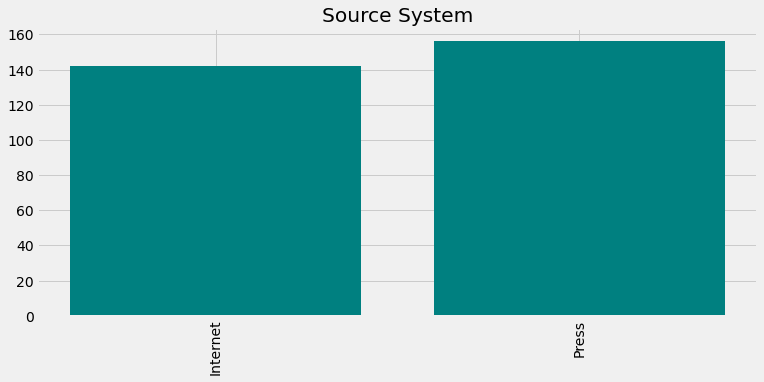

In [67]:
display_groups(docs, 'source_system', 'Source System')

We can cluster either by article type, by media type or prospect keywords. The number of articles differs highly among different categories.

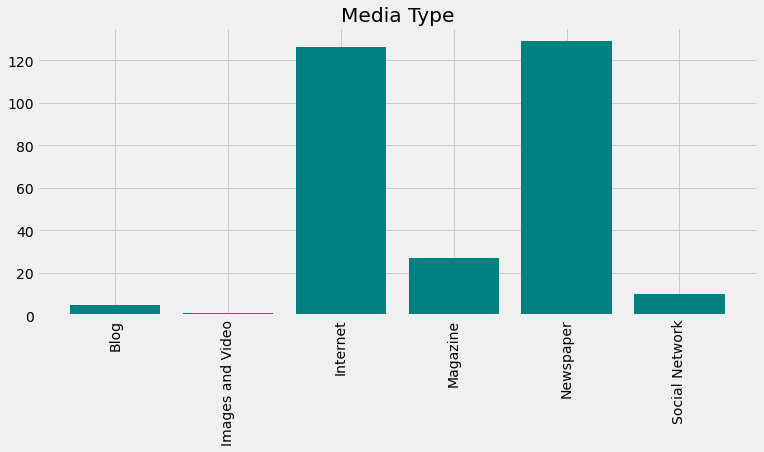

In [69]:
display_groups(docs, 'media_type', 'Media Type')

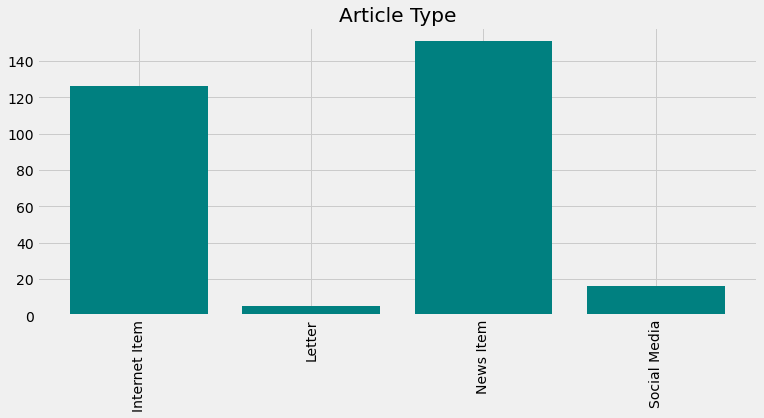

In [71]:
display_groups(docs, 'article_type', 'Article Type')

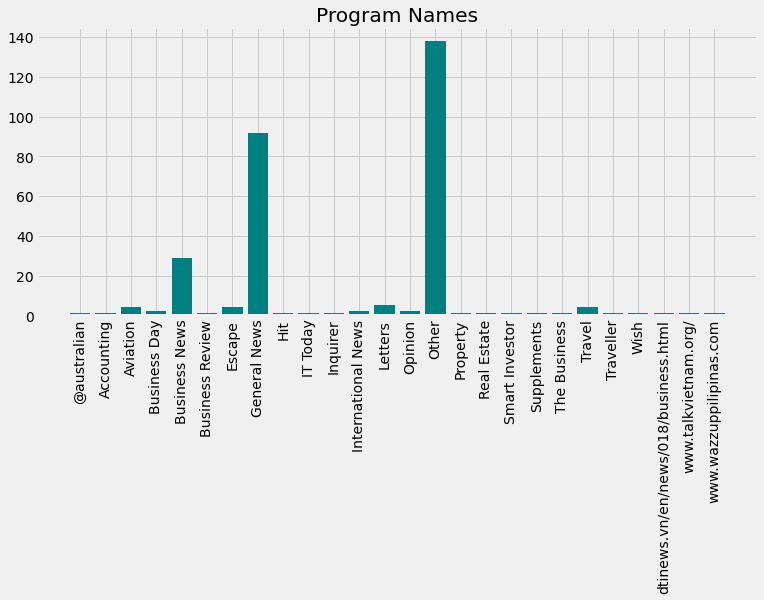

In [66]:
display_groups(docs, 'program_name', 'Program Names')

media_type and commentator columns are linked to the respective media_type_id and commentator_id. Not the same case for program_name where one program name can have multiple program_ids, e.g. Business News generalizes multiple business news programs.

I will set the media_type, program_name, article_type and source_system columns as category type

Test kmode for clustering categorical data: 
- https://datascience.stackexchange.com/questions/48473/kmeans-clustering-with-multiple-columns-containing-strings
- https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
Use word2vec and kmeans as a main clustering algorithm.
Compare results.

In [73]:
convert_dict = {'media_type': 'category',
                'article_type': 'category',
                'source_system': 'category'
               }
  
docs = docs.astype(convert_dict)
# docs.info()

In [80]:
kmode_data = docs[['id', 'media_type', 'article_type', 'source_system']]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 755.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 755.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 755.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 755.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 755.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 360.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 140, cost: 361.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, 

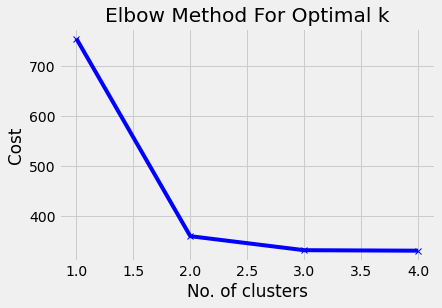

In [81]:
# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(kmode_data)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [82]:
# Building the model with 2 clusters
kmode = KModes(n_clusters=2, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(kmode_data)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 360.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 754.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 360.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 754.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 360.0
Best run was number 1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], dtype=u

In [84]:
kmode_data.insert(0, "Cluster", clusters, True)
kmode_data

,Cluster,id,media_type,article_type,source_system
0,1,AVf1MzEjpI2L3kY8EWkf,Magazine,News Item,Press
1,1,AVf1MzEjpI2L3kY8EWkg,Magazine,News Item,Press
2,1,AVf1MzEjpI2L3kY8EWkk,Magazine,News Item,Press
3,1,AVf1MzEjpI2L3kY8EWko,Magazine,News Item,Press
4,1,AVf1MzEjpI2L3kY8EWkr,Newspaper,News Item,Press
5,1,AVf1MzEjpI2L3kY8EWk0,Magazine,News Item,Press
6,1,AVf1MzEjpI2L3kY8EWk1,Magazine,News Item,Press
7,1,AVf1MzEjpI2L3kY8EWk2,Magazine,News Item,Press
8,1,AVf1MzEjpI2L3kY8EWk3,Magazine,News Item,Press
9,1,AVf1MzEjpI2L3kY8EWk4,Magazine,News Item,Press


In [96]:
cluster_one = pd.DataFrame(kmode_data[kmode_data['Cluster']==1].groupby(['media_type', 'article_type', 'source_system']).count())

In [101]:
cluster_one = cluster_one[cluster_one['id']>0]

In [103]:
cluster_one

Cluster   id
media_type article_type source_system              
Magazine   News Item    Press               27   27
Newspaper  Letter       Press                5    5
           News Item    Press              124  124

In [99]:
cluster_zero = pd.DataFrame(kmode_data[kmode_data['Cluster']==0].groupby(['media_type', 'article_type', 'source_system']).count())

In [102]:
cluster_zero = cluster_zero[cluster_zero['id']>0]

In [104]:
cluster_zero

,,,Cluster,id
media_type,article_type,source_system,,
Blog,Social Media,Internet,5,5
Images and Video,Social Media,Internet,1,1
Internet,Internet Item,Internet,126,126
Social Network,Social Media,Internet,10,10


In [105]:
kmode_data.loc[kmode_data['Cluster'] == 'Traditional Press', 'Cluster'] = 1

C:\Users\Az\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
